In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import scipy
from scipy import stats
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import seaborn as sns
from math import sqrt

In [15]:
# Import data from pre-processed final_combined_data.csv
data = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Fall/CSRA/QualityCheck/test/final_combined_data.csv')
wt_df = data[data['NeuronType'] == 'WT']
wt_df.shape

# # Or use the following example data
# wt_df = pd.read_csv('wt_data.csv') # wt_data is the data file
# wt_df.shape

(694, 28)

In [17]:
# filter out the activity outliers
def threshold_filter(data):
    data_subset = data[data['DIV'] > 7].copy()
    data_outliers = data_subset[data_subset['Active_area'] <= 35]
    data_outliers_unique = data_outliers[['Chip_ID', 'Well','Trial']].drop_duplicates()
    return data_outliers_unique
def z_score_filter(data):
    data_subset = data[data['DIV'] > 7].copy()
    data_subset['Z_score'] = data_subset.groupby(['DIV', 'Trial'])['Active_area'].transform(lambda x: stats.zscore(x))
    z_threshold = 2
    data_z_outliers = data_subset[(data_subset['Z_score'] > z_threshold) | (data_subset['Z_score'] < -z_threshold)]
    data_z_outliers_unique = data_z_outliers[['Chip_ID', 'Well','Trial','DIV']].drop_duplicates()
    return data_z_outliers_unique

In [18]:
# Remove z-score outliers by div
activity_outlier = z_score_filter(wt_df)

# Remove z-score outliers based on combination of Chip_ID, Well, Trial, and DIV
mask = wt_df[['Chip_ID', 'Well', 'Trial', 'DIV']].apply(tuple, 1).isin(activity_outlier[['Chip_ID', 'Well', 'Trial', 'DIV']].apply(tuple, 1))
wt_z_data = wt_df[~mask].copy()  

# Remove threshold outliers globally
activity_outlier = threshold_filter(wt_df)

# Convert 'Chip_ID' and 'Well' in activity_outlier to a single string column for comparison
activity_outlier['ID_Well'] = activity_outlier['Chip_ID'] + '_' + activity_outlier['Well'].astype(str)

# Do the same conversion in wt_z_data using .loc to avoid SettingWithCopyWarning
wt_z_data.loc[:, 'ID_Well'] = wt_z_data['Chip_ID'] + '_' + wt_z_data['Well'].astype(str)

# Use isin() with the combined column
wt_data = wt_z_data[~wt_z_data['ID_Well'].isin(activity_outlier['ID_Well'])]

# Drop the helper column 'ID_Well' if no longer needed
wt_data = wt_data.drop(columns='ID_Well')
print(wt_data.shape)

(604, 28)


In [19]:
# dynamic select divs function
def select_divs_around_center(data, lower_limit, upper_limit, center_div):

    # Filter DIVs between specified limits
    select_div_data = data[(data['DIV'] >= lower_limit) & (data['DIV'] <= upper_limit)]

    # Calculate the number of unique DIVs in each trial
    count_divs = select_div_data.groupby('Trial')['DIV'].nunique()

    # Find the minimum number of DIVs present across trials
    min_divs_count = int(count_divs.min())

    # Initialize results dictionary and an empty DataFrame for results
    results = {}
    filtered_dataset = pd.DataFrame()

    # Process each trial to fit within the centered range around the specified center DIV
    for trial in select_div_data['Trial'].unique():
        trial_data = select_div_data[select_div_data['Trial'] == trial].copy()  # Ensure working on a copy
        trial_data['Difference'] = (trial_data['DIV'] - center_div).abs()
        trial_data_sorted = trial_data.sort_values(by='Difference')
        
        # Get the closest DIVs based on the sorted data
        closest_div_index = trial_data_sorted.index[0]  # Getting the index of the closest div
        closest_div = trial_data_sorted.loc[closest_div_index, 'DIV']

        # Select a range of DIVs around the closest DIV
        possible_divs = trial_data_sorted['DIV'].values
        div_range = sorted(np.unique(possible_divs))  # Unique and sorted DIVs available in this trial
        
        # Determine closest possible range around the chosen center
        center_index = list(div_range).index(closest_div)
        low = max(0, center_index - min_divs_count // 2)
        high = min(len(div_range), low + min_divs_count)
        
        # Adjust if not enough DIVs to the right
        if high - low < min_divs_count:
            low = max(0, high - min_divs_count)
        
        # Final selection of DIVs
        selected_divs = div_range[low:high]
        results[trial] = f"Selected DIVs in trial {trial}: {', '.join(map(str, selected_divs))} (Count: {len(selected_divs)})"
        
        # Append the filtered data for these DIVs back into a DataFrame
        trial_filtered_data = trial_data[trial_data['DIV'].isin(selected_divs)]
        filtered_dataset = pd.concat([filtered_dataset, trial_filtered_data], ignore_index=True)

    # Print results and return the filtered dataset
    for trial, result in results.items():
        print(trial, result)
    
    return filtered_dataset

In [20]:
# select divs around center div
lower_limit = 7
upper_limit = 28
center_div = 21

select_div_data = select_divs_around_center(wt_data, lower_limit, upper_limit, center_div)

CDKL5-E6D_T1_C1_05152024 Selected DIVs in trial CDKL5-E6D_T1_C1_05152024: 13, 16, 20, 23, 27 (Count: 5)
SYNGAP1_T1_C1_03212024 Selected DIVs in trial SYNGAP1_T1_C1_03212024: 12, 15, 19, 22, 26 (Count: 5)
ADNP_T2_10262023 Selected DIVs in trial ADNP_T2_10262023: 14, 18, 21, 25, 27 (Count: 5)
KCNT1_T3_C1_03122024 Selected DIVs in trial KCNT1_T3_C1_03122024: 14, 16, 21, 24, 28 (Count: 5)
SPTAN1_T1_07192023 Selected DIVs in trial SPTAN1_T1_07192023: 13, 16, 20, 23, 27 (Count: 5)
KCNT1_T1_08082023 Selected DIVs in trial KCNT1_T1_08082023: 14, 17, 21, 24, 28 (Count: 5)
ADNP_T3_11072023 Selected DIVs in trial ADNP_T3_11072023: 10, 14, 21, 24, 28 (Count: 5)
SHANK3_T1_11222023 Selected DIVs in trial SHANK3_T1_11222023: 13, 16, 20, 23, 27 (Count: 5)
ADNP_T4_C1_06282024 Selected DIVs in trial ADNP_T4_C1_06282024: 14, 18, 21, 25, 28 (Count: 5)
CHD8_T2_C1_08252023 Selected DIVs in trial CHD8_T2_C1_08252023: 13, 18, 21, 25, 28 (Count: 5)


In [21]:
# select features
basic_info = ['Trial','DIV']
basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
                  'mean_Burst_Peak', 'Number_Bursts', 'mean_Spike_per_Burst']
basic_data = select_div_data[basic_info + basic_features]

# look at missing values
missing_data = basic_data[basic_data.isna().any(axis=1)]
print(missing_data)
# Remove missing values
basic_data = basic_data.dropna()

# average numbers across chips in same div for each trial
combined_data = basic_data.groupby(['Trial', 'DIV']).mean().reset_index()

Empty DataFrame
Columns: [Trial, DIV, Mean_FiringRate, Mean_SpikeAmplitude, Active_area, mean_Burst_Peak, Number_Bursts, mean_Spike_per_Burst]
Index: []


In [22]:
# config entropy matrix, with div info
feature_cols = basic_features
entropy_trials = np.array(sorted(combined_data['Trial'].unique()))

count_divs = combined_data.groupby('Trial')['DIV'].count().iloc[0]

num_trials = len(entropy_trials)
num_features = len(feature_cols)
num_divs = count_divs
columns_per_trial = num_divs * num_features

# Initialize the entropy matrix
entropy_matrix = np.zeros((num_trials, columns_per_trial))

# Populate the matrix
for idx, trial in enumerate(entropy_trials):
    # Filter data for the current trial
    trial_data = combined_data[combined_data['Trial'] == trial]
    trial_data = trial_data.sort_values('DIV')  # Ensure the data is in DIV order
    
    # Flatten the trial data across DIVs for each feature
    trial_features = []
    for feature in feature_cols:
        trial_features.extend(trial_data[feature].tolist())  # Append feature data in DIV order
    
    # Store in the matrix
    entropy_matrix[idx, :] = trial_features

In [23]:
# plotting all lines(aggregated) with central data
def plot_feature_entropy_line(entropy_matrix, feature_index, num_divs, num_trials, feature_name, trials, path):
    # Extract the relevant section of the matrix for the selected feature
    feature_data = entropy_matrix[:, feature_index * num_divs: (feature_index + 1) * num_divs]
    
    # Calculate reference (mean and standard deviation across trials) for each DIV
    mean_data = np.mean(feature_data, axis=0)
    std_data = np.std(feature_data, axis=0)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(num_divs)  # Positions for each DIV
    
    # Plot each trial's data as a line
    for i in range(num_trials):
        ax.plot(x, feature_data[i, :], marker='o', linestyle='-', label=f'{trials[i]}')
    
    # Plot the mean as a bold line and the std deviation as a shaded area
    ax.plot(x, mean_data, color='black', linewidth=2, label='Mean')
    ax.fill_between(x, mean_data - 1.5*std_data, mean_data + 1.5*std_data, color='gray', alpha=0.3, label='Mean ± 1.5 STD')
    
    # Customize the plot
    ax.set_title(f'Feature Analysis Across Trials: {feature_name}')
    ax.set_xlabel('Selected DIVs centered at DIV 21')
    ax.set_ylabel(f'{feature_name} Value')

    # Specific DIVs as requested
    div_labels = [14, 18, 21, 25, 27]  # Specific DIVs to display on X-axis
    ax.set_xticks(np.linspace(0, num_divs-1, len(div_labels)))  # Set the positions for the labels
    ax.set_xticklabels([f'{div}' for div in div_labels])  # Set the custom labels

    # Adjust legend
    legend = ax.legend(title='mean value acorss all chips', loc='upper right', fontsize='small', 
                       bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure)
    plt.subplots_adjust(right=0.85) 
    # save figures use it's feature name as png
    plt.savefig(f'{path}/{feature_name}_analysis.png')
    # Show the plot
    plt.show()
    return fig

In [ ]:
path = '/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Fall/CSRA/QualityCheck/test'

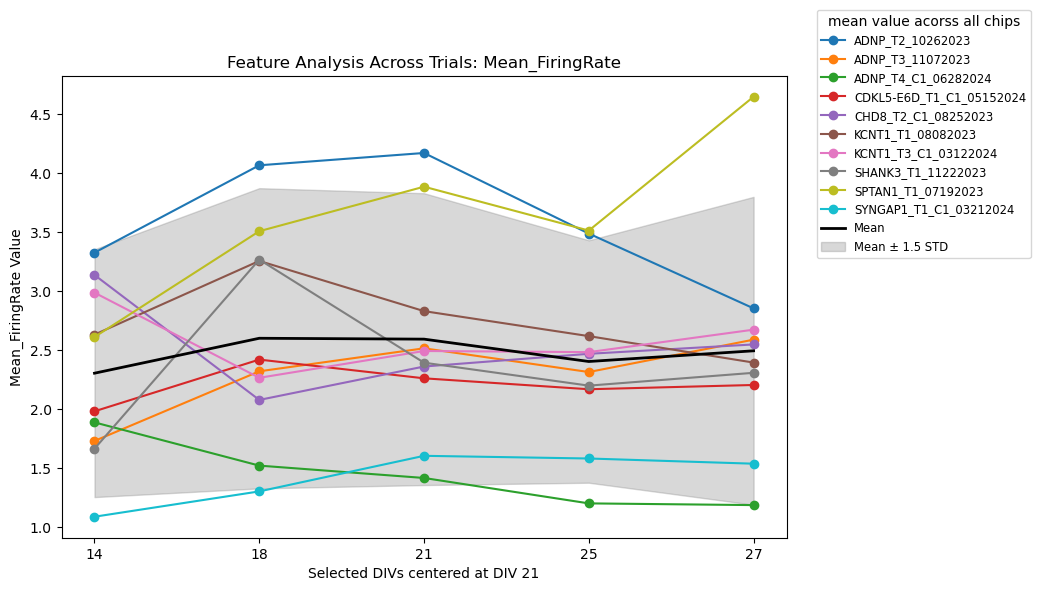

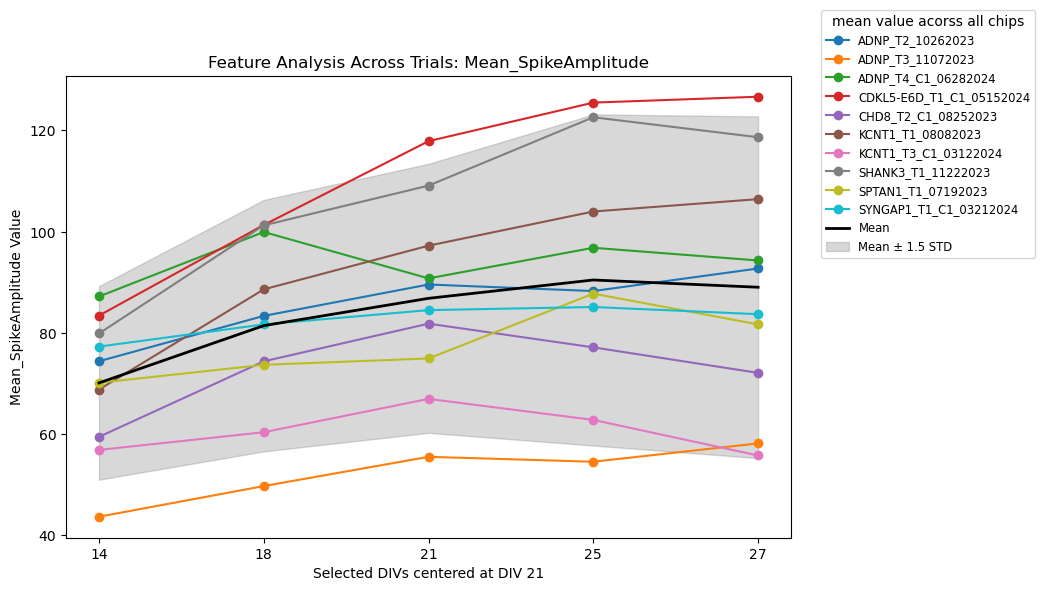

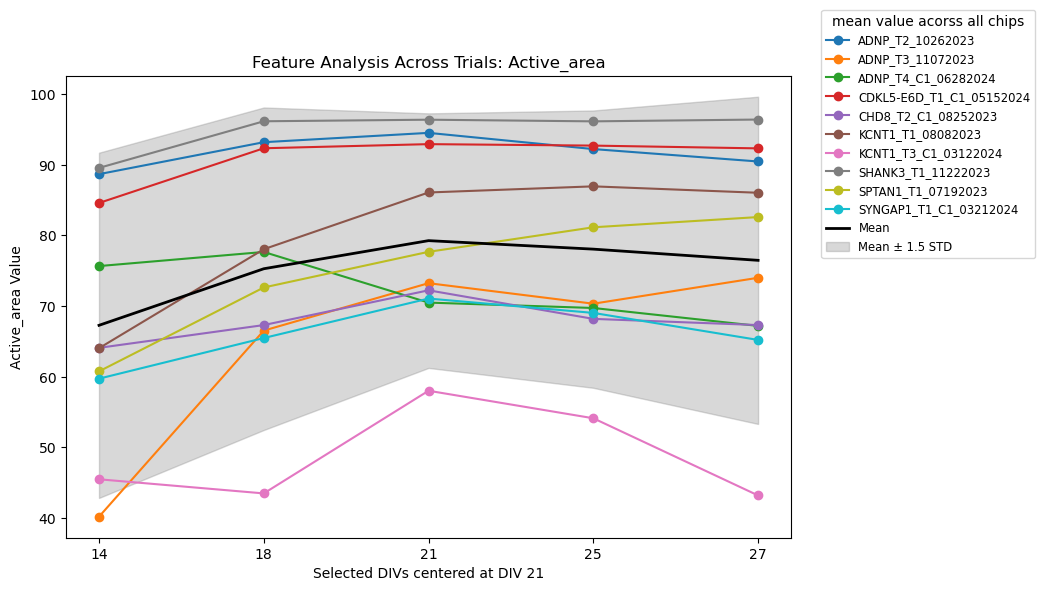

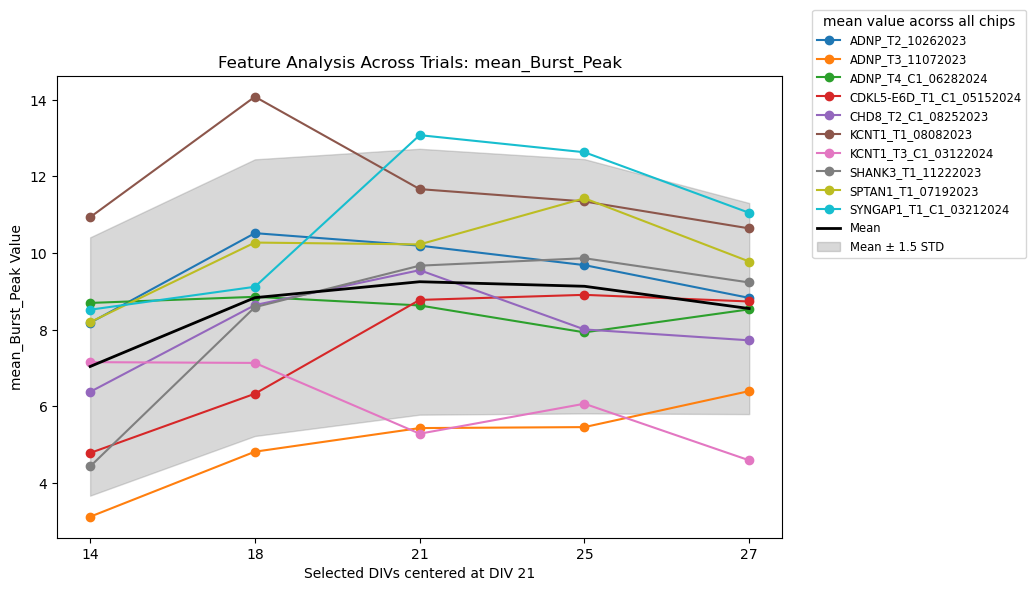

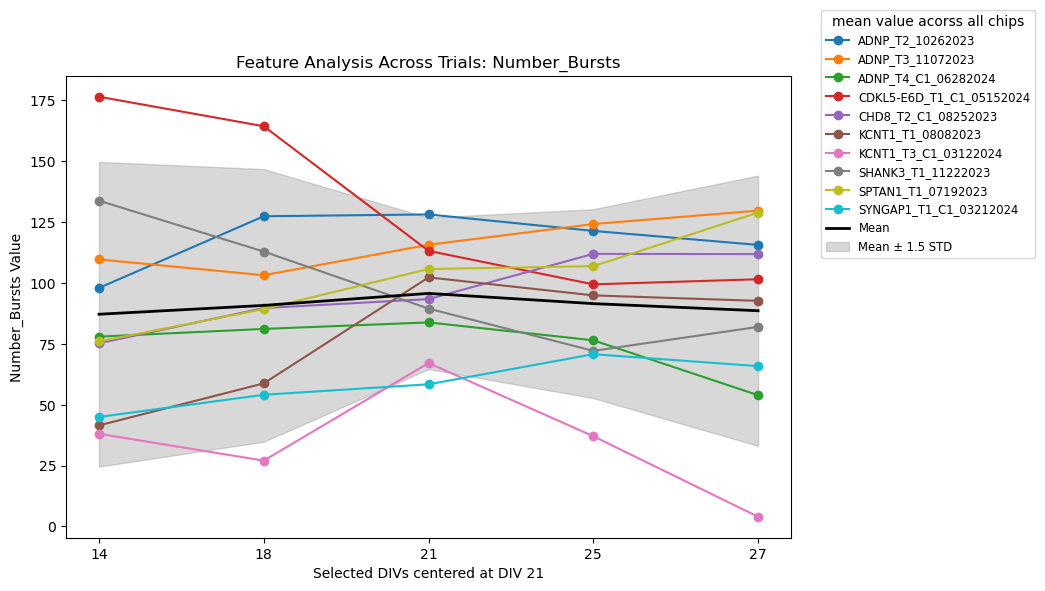

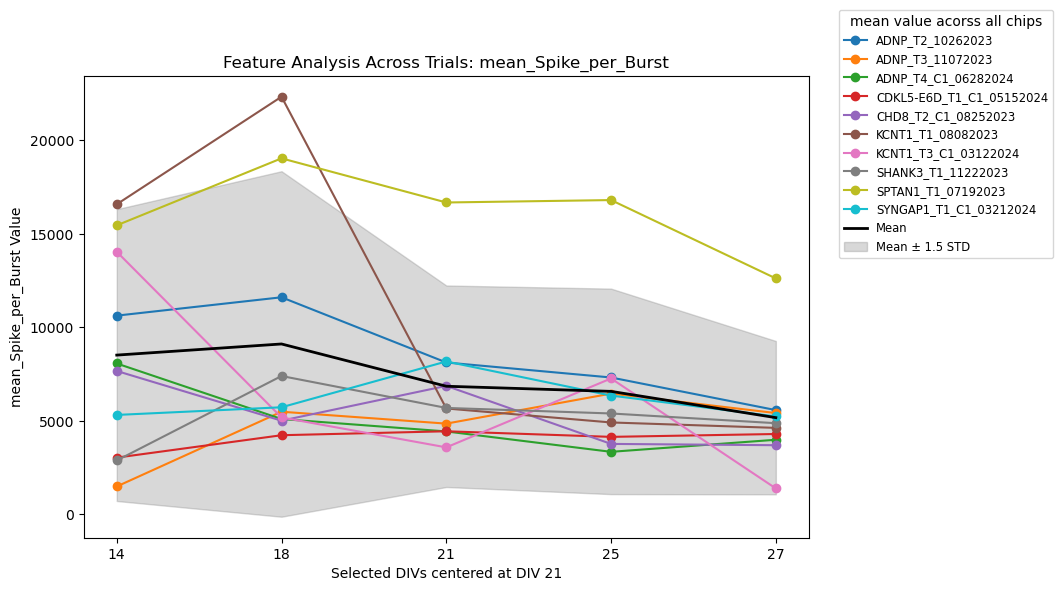

In [24]:
for feature_index, feature_name in enumerate(feature_cols):
    plot_feature_entropy_line(entropy_matrix, feature_index, num_divs, num_trials, 
                         feature_name, entropy_trials, path)

In [25]:
# Plotting the all chips for selected DIV (eg, DIV 21)
def plot_bar_div21(data, center_div, output_types,path):
    div21_data = pd.DataFrame()
    for trial in data['Trial'].unique():
        trial_data = data[data['Trial'] == trial].copy()  # Ensure working on a copy
        trial_data['Difference'] = (trial_data['DIV'] - center_div).abs()
        trial_data_sorted = trial_data.sort_values(by='Difference')
        
        # Get the closest DIVs based on the sorted data
        closest_div_index = trial_data_sorted.index[0]  # Getting the index of the closest div
        closest_div = trial_data_sorted.loc[closest_div_index, 'DIV']
        closest_div_data = trial_data[trial_data['DIV'] == closest_div]
        div21_data = pd.concat([div21_data, closest_div_data], ignore_index=True)


    # Define output types
    output_types = basic_features
    # Get unique trials from the data and modify names
    unique_trials = div21_data['Trial'].unique()
    modified_trials = ['_'.join(trial.split('_')[:2]) for trial in unique_trials]

    # Create a subplot grid
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust horizontal and vertical spaces

    # Calculate global statistics for all features
    all_data_stats = {feature: {} for feature in output_types}
    for feature in output_types:
        all_feature_data = div21_data[feature].dropna()
        all_data_stats[feature]['mean'] = all_feature_data.mean()
        all_data_stats[feature]['std'] = all_feature_data.std()

    for index, output_type in enumerate(output_types):
        ax = axes[index // 3, index % 3]  # Determine the position of the subplot

        output_means = []
        output_errs = []
        output_all_data = []

        # Collect data for plotting
        for i, trial in enumerate(unique_trials):
            temp_df = div21_data[div21_data['Trial'] == trial]
            values = temp_df[output_type].dropna()

            mean_val = values.mean()
            stderr_val = values.sem()  # Standard error of the mean

            output_means.append(mean_val)
            output_errs.append(stderr_val)
            output_all_data.append(values)

        # Plotting on designated axes
        x_positions = np.arange(len(modified_trials))
        bars = ax.bar(x_positions, output_means, yerr=output_errs, capsize=3, color='royalblue', label='Mean with SEM')

        # Add scatter plot inside the bars
        for i, trial_data in enumerate(output_all_data):
            jitter = np.random.normal(0, 0.04, size=len(trial_data))
            ax.scatter(x_positions[i] + jitter, trial_data, color='darkblue', alpha=0.7, s=10)

        # Plot mean and std lines for all trials
        global_mean = all_data_stats[output_type]['mean']
        global_std = all_data_stats[output_type]['std']

        ax.axhline(y=global_mean, color='green', linestyle='-', label='Global Mean')
        ax.axhline(y=global_mean + 1.5 * global_std, color='red', linestyle='--', label='+1.5 STD')
        ax.axhline(y=global_mean - 1.5 * global_std, color='red', linestyle='--', label='-1.5 STD')

        # Aesthetics
        ax.set_xticks(x_positions)
        ax.set_xticklabels(modified_trials, rotation=45, ha="right")
        ax.set_title(f"{output_type} at around DIV {center_div}", fontsize=14)
        ax.set_xlabel('Trial', fontsize=12)
        ax.set_ylabel(f"{output_type}", fontsize=12)

    # Add legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
    plt.savefig(f'{path}/div{center_div}_analysis.png')
    plt.show()
    return fig

In [ ]:
center_div = 21
save_path = '/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Fall/CSRA/QualityCheck/test'

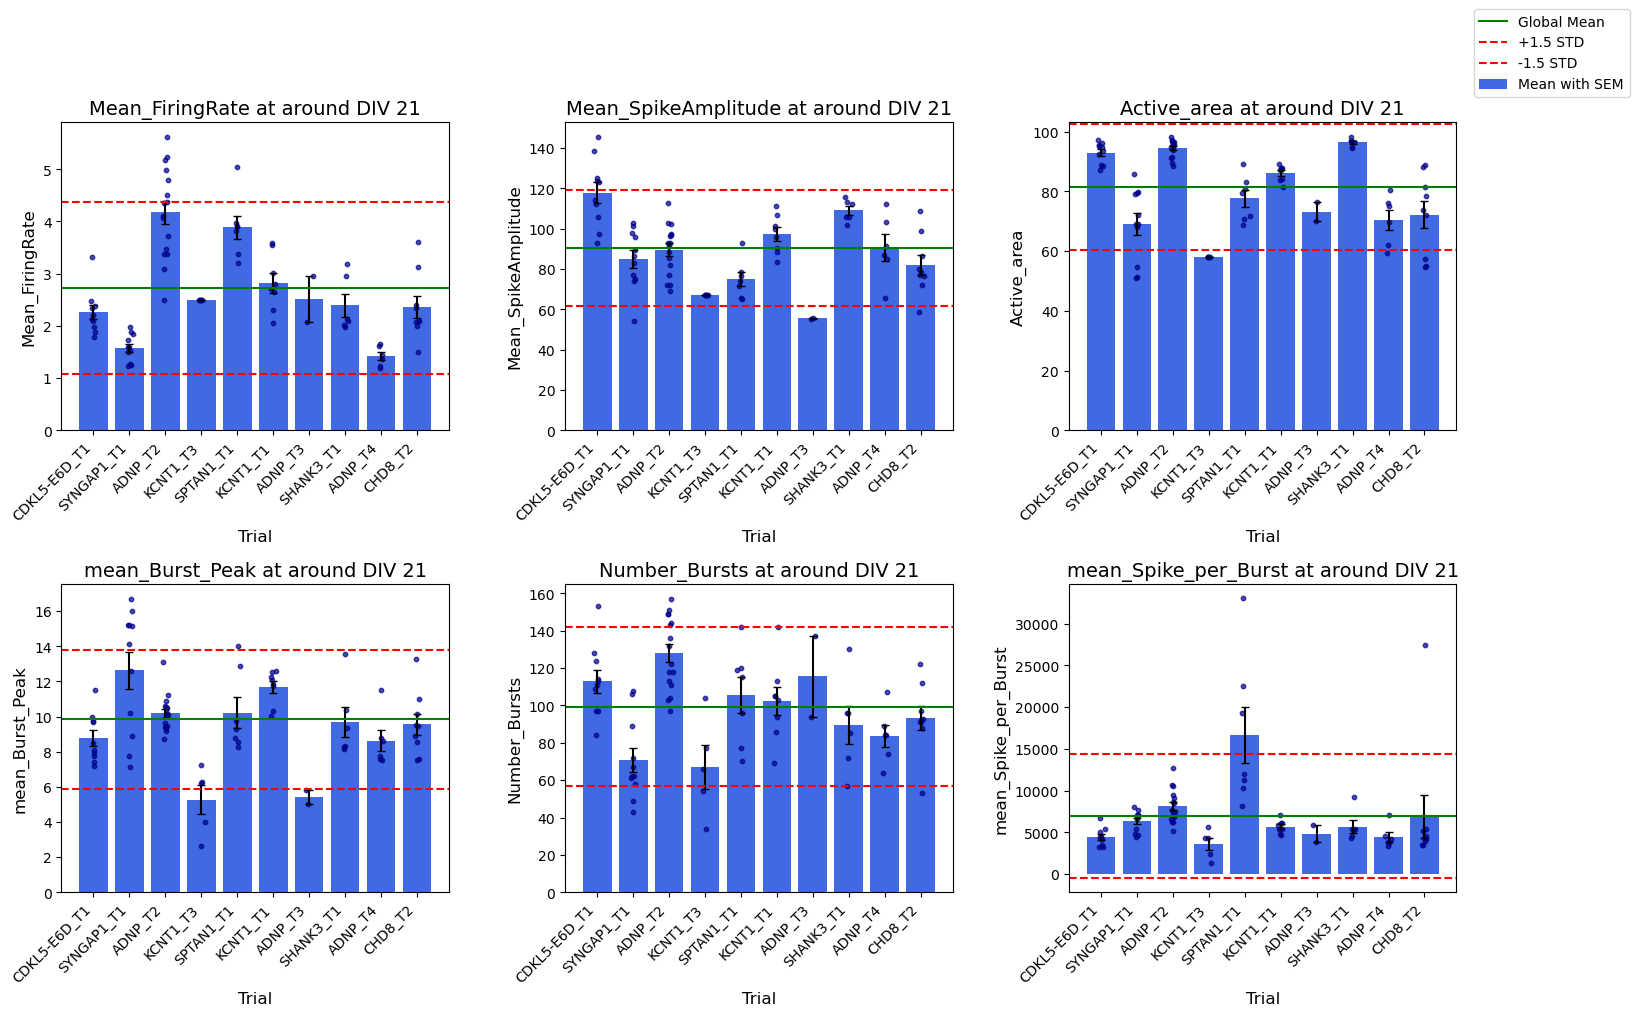

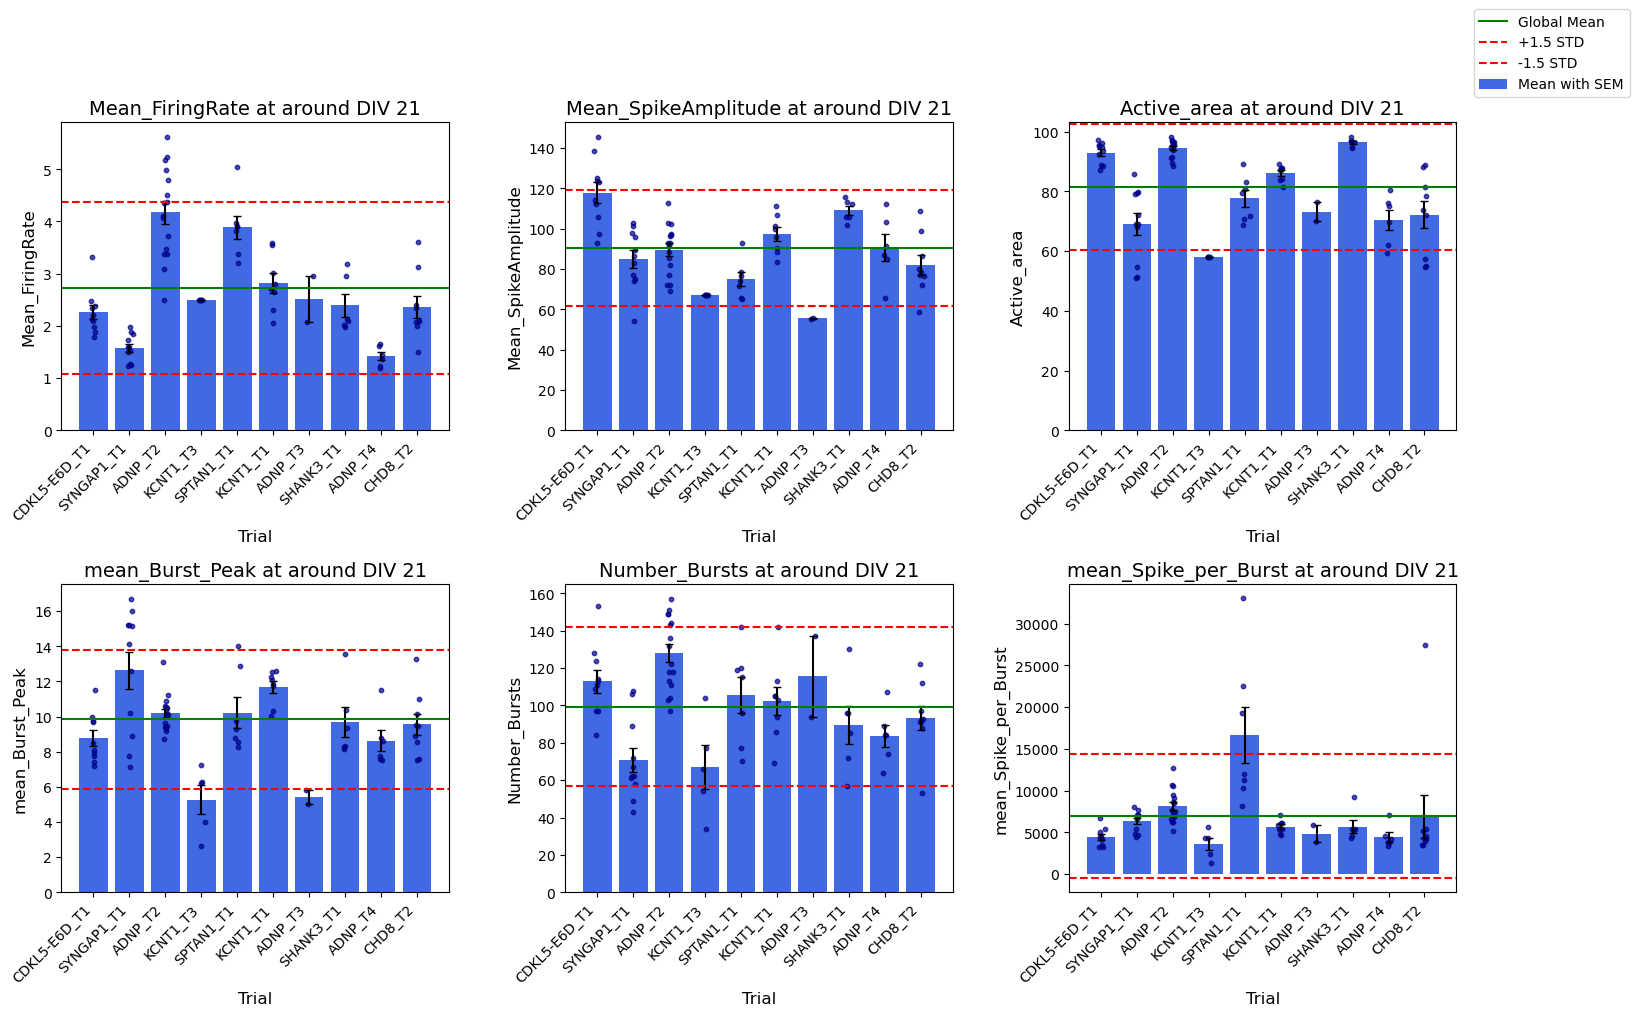

In [26]:
plot_bar_div21(wt_data, center_div, basic_features, save_path)